## Objectives

- Use validation set to report results
- Note these are two different experiments with two different datasets

- Test DF-detector vs. megadetector using DF-classifier
    - confidence_threshold = 0.01 - 0.99
    - Use full dataset
    - Precision/recall/F1 for animal/human/vehicle/empty (do wild boar deep verification)

## Detect Test Rig

### Get results from DeepFaune's Yolov8s model

In [ ]:
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm

# Define paths
excel_path = "../data/detector_tests/labelled_photos_file_paths.xlsx"
model_path = "../models/deepfaune-yolov8s_960.pt"

# Load the Excel file
df = pd.read_excel(excel_path)

# Load the YOLOv8 model
model = YOLO(model_path, verbose=False)
model.conf = 0.005  # Set confidence threshold

# Suppress YOLO logs
import logging
logging.getLogger('ultralytics').setLevel(logging.WARNING)

# Function to process a batch of images
def process_batch(image_paths):
    results = model(image_paths, conf=0.005, task='detect')
    batch_detections = []
    batch_confidences = []
    for result in results:
        if result.boxes is None or len(result.boxes) == 0:
            batch_detections.append("Empty")
            batch_confidences.append(0)
        else:
            highest_conf_detection = max(result.boxes, key=lambda x: x.conf[0])  # Access the highest confidence detection
            category = highest_conf_detection.cls[0].item()  # Access the class/category index
            confidence = highest_conf_detection.conf[0].item()  # Access the confidence score
            
            if category == 0:
                batch_detections.append("Animal")
            elif category == 1:
                batch_detections.append("Human")
            elif category == 2:
                batch_detections.append("Vehicle")
            else:
                batch_detections.append("Unknown")
                
            batch_confidences.append(confidence)
    return batch_detections, batch_confidences

# Process images in batches with progress bar
batch_size = 32  # 32 = 3.6GB of VRAM
image_paths = df['New File Name'].tolist()
batch_results = []
batch_confidences = []

# Initialize progress bar
with tqdm(total=len(image_paths), desc="Processing images", unit="image") as pbar:
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        detections, confidences = process_batch(batch)
        batch_results.extend(detections)
        batch_confidences.extend(confidences)
        pbar.update(len(batch))

# Add or update the 'DF_Detector' and 'DF_Detector_Conf' columns in the DataFrame
df['DF_Detector'] = batch_results
df['DF_Detector_Conf'] = batch_confidences

# Save the updated DataFrame back to Excel
df.to_excel(excel_path.replace('.xlsx', '_updated.xlsx'), index=False)


### Compare DeepFaune's YOLOv8 Detection Model with MegaDetector v5a / YOLOv5

Megadetector results already stored in excel file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/detector_tests/data.csv')

# Filter out rows where Ground_Truth_Detect has no value ("")
# This is where Ground_Truth = Unknown or Exclude
df = df[df['Ground_Truth_Detect'] != ""]

# Function to map labels to "Empty" and "Not Empty"
# Human/Vehicle/Animal grouped as often they all appear in the same image
def map_labels(label):
    if label == "Empty":
        return "Empty"
    else:
        return "Not Empty"


# Apply the label mapping
df['Ground_Truth_Detect'] = df['Ground_Truth_Detect'].apply(map_labels)
df['MD_Category'] = df['MD_Category'].apply(map_labels)
df['DF_Detector'] = df['DF_Detector'].apply(map_labels)

# Function to apply the confidence threshold logic
def apply_threshold(row, detector_conf, detector_label, threshold):
    if row[detector_conf] <= threshold:
        return "Empty"
    else:
        return row[detector_label]

# Function to calculate precision, recall, and F1 score at different thresholds
def calculate_metrics(df, detector_label, detector_conf, ground_truth_label):
    thresholds = np.arange(0.00, 0.99, 0.01)
    precision = []
    recall = []
    f1_scores = []
    
    for threshold in thresholds:
        # Apply threshold logic
        df['Filtered_Label'] = df.apply(lambda row: apply_threshold(row, detector_conf, detector_label, threshold), axis=1)
        
        # Calculate TP, FP, FN
        TP = ((df['Filtered_Label'] == 'Not Empty') & (df[ground_truth_label] == 'Not Empty')).sum()
        FP = ((df['Filtered_Label'] == 'Not Empty') & (df[ground_truth_label] == 'Empty')).sum()
        FN = ((df['Filtered_Label'] == 'Empty') & (df[ground_truth_label] == 'Not Empty')).sum()
        
        # Calculate precision and recall
        precision_val = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # Calculate F1 score
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        precision.append(precision_val)
        recall.append(recall_val)
        f1_scores.append(f1_val)
    
    return thresholds, precision, recall, f1_scores

# Calculate metrics for MegaDetector
thresholds, mega_precision, mega_recall, mega_f1 = calculate_metrics(df, 'MD_Category', 'MD_Confidence', 'Ground_Truth_Detect')

# Calculate metrics for DeepFaune
_, df_precision, df_recall, df_f1 = calculate_metrics(df, 'DF_Detector', 'DF_Detector_Conf', 'Ground_Truth_Detect')

results_df = pd.DataFrame({
    'Threshold': thresholds,
    'MegaDetector_Precision': mega_precision,
    'MegaDetector_Recall': mega_recall,
    'MegaDetector_F1': mega_f1,
    'DeepFaune_Precision': df_precision,
    'DeepFaune_Recall': df_recall,
    'DeepFaune_F1': df_f1
})

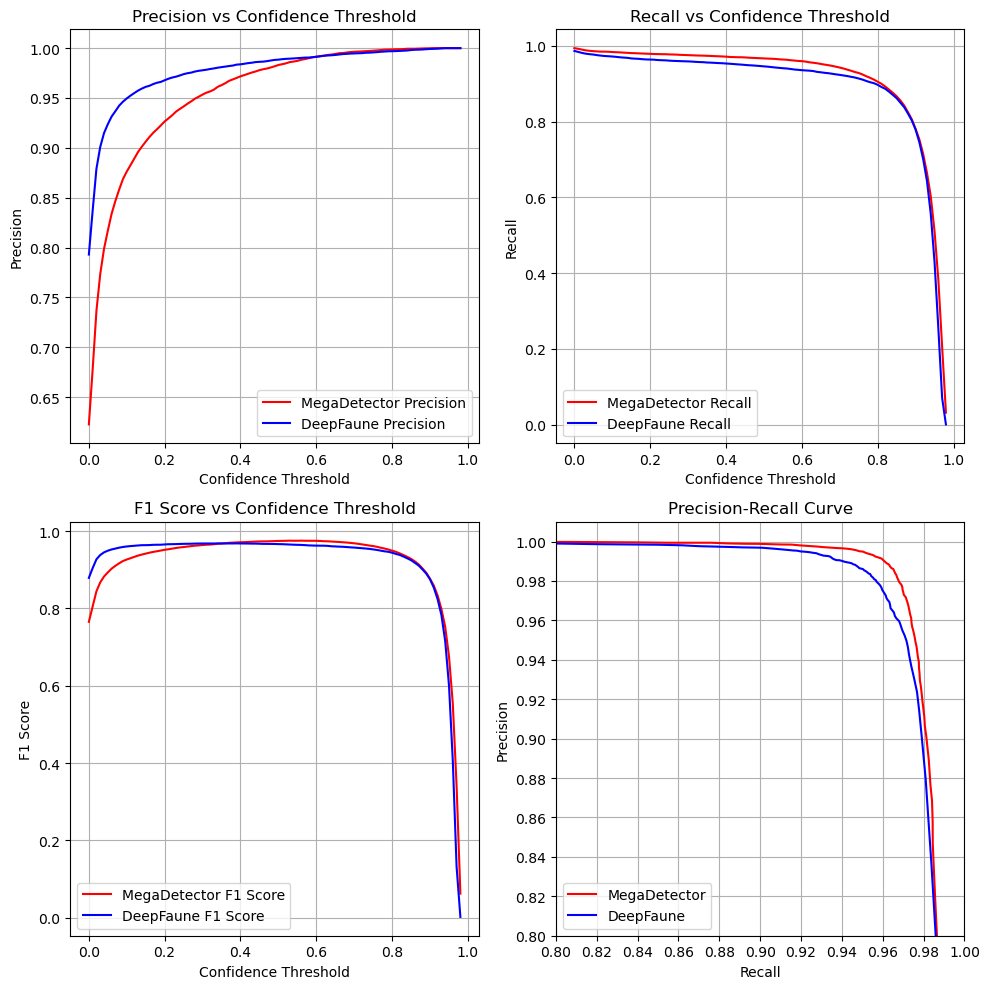

In [10]:
# Plot the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# Precision Plot
ax1.plot(thresholds, mega_precision, 'r-', label='MegaDetector Precision')
ax1.plot(thresholds, df_precision, 'b-', label='DeepFaune Precision')
ax1.set_xlabel('Confidence Threshold')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Confidence Threshold')
ax1.legend()
ax1.grid(True)

# Recall Plot
ax2.plot(thresholds, mega_recall, 'r-', label='MegaDetector Recall')
ax2.plot(thresholds, df_recall, 'b-', label='DeepFaune Recall')
ax2.set_xlabel('Confidence Threshold')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Confidence Threshold')
ax2.legend()
ax2.grid(True)

# F1 Score Plot
ax3.plot(results_df['Threshold'], results_df['MegaDetector_F1'], 'r-', label='MegaDetector F1 Score')
ax3.plot(results_df['Threshold'], results_df['DeepFaune_F1'], 'b-', label='DeepFaune F1 Score')
ax3.set_xlabel('Confidence Threshold')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score vs Confidence Threshold')
ax3.legend()
ax3.grid(True)

# Precision-Recall Plot
ax4.plot(results_df['MegaDetector_Recall'], results_df['MegaDetector_Precision'], 'r-', label='MegaDetector')
ax4.plot(results_df['DeepFaune_Recall'], results_df['DeepFaune_Precision'], 'b-', label='DeepFaune')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curve')
ax4.legend()
ax4.grid(True)
ax4.set_xlim(0.8, 1.0)
ax4.set_ylim(0.8, 1.01)
ax4.set_xticks(np.arange(0.8, 1.02, 0.02))
ax4.set_yticks(np.arange(0.8, 1.02, 0.02))

plt.tight_layout()
plt.show()

In [ ]:
# Filter the DataFrame to include only the specified thresholds

# Print the results table
results_df


In [13]:
filtered_results_df = results_df[results_df['Threshold'].isin([0.1, 0.15, 0.2, 0.25])]

filtered_results_df

,Threshold,MegaDetector_Precision,MegaDetector_Recall,MegaDetector_F1,DeepFaune_Precision,DeepFaune_Recall,DeepFaune_F1
10,0.10,0.876189,0.983357,0.926685,0.949553,0.971628,0.960464
16,0.16,0.910943,0.980346,0.944371,0.962261,0.965922,0.964088
20,0.20,0.926474,0.978655,0.951850,0.967790,0.963597,0.965689
25,0.25,0.941509,0.977175,0.959011,0.973915,0.960691,0.967258


In [8]:
filtered_results_df = results_df[results_df['Threshold'].isin([0.01, 0.02, 0.03, 0.04])]

filtered_results_df

,Threshold,MegaDetector_Precision,MegaDetector_Recall,MegaDetector_F1,DeepFaune_Precision,DeepFaune_Recall,DeepFaune_F1
1,0.01,0.677493,0.991916,0.805095,0.836854,0.983780,0.904388
2,0.02,0.736439,0.989856,0.844547,0.879000,0.981032,0.927218
3,0.03,0.773338,0.987848,0.867530,0.900875,0.979078,0.938350
4,0.04,0.798606,0.986580,0.882696,0.914780,0.977757,0.945221
